In [50]:
from time import time

import nest_asyncio
import pyarrow.feather as feather
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from models.CNN_2D import create_keras_model
from pathlib import Path

nest_asyncio.apply()
SEED = 1337
tf.random.set_seed(SEED)
import gc

gc.collect()


919

In [51]:
EXPERIMENT_NAME = "merge"
this_dir = Path.cwd()
print(this_dir)

/home/bkcs/Documents/doh/doh-exfiltration-detector


# Load data

In [52]:
data_dir = this_dir / "datasets" / "csvs"

# benign_data = pd.read_csv(data_dir / "benign.csv")
# dnscat2_data = pd.read_csv(data_dir / "dnscat2.csv")
# Đường dẫn tới thư mục chứa dữ liệu CSV
# data_dir =

# Đọc các file CSV và nối chúng lại
# Get all file in this directory
# benign_files = [child for child in (data_dir / "CSVs").iterdir() if child.is_file()]

# benign_data = null
# benign_data = pd.concat([pd.read_csv(file, ) for file in benign_files])
benign_data = pd.read_csv(data_dir / "CSVs/benign_chrome_adguard.csv", nrows=100)

# Đọc các file CSV khác
dnscat2_data = pd.read_csv(data_dir / "dnscat2.csv", nrows=100)
dns2tcp_data = pd.read_csv(data_dir / "dns2tcp.csv", nrows=100)
iodine_data = pd.read_csv(data_dir / "iodine.csv", nrows=100)

# dnscat2_data = dnscat2_data.drop("type", axis=1)
# dnscat2_data['label'] = dnscat2_data['type']

In [57]:
benign_data.groupby('flow_id').size().count()

10

In [58]:
dnscat2_data.groupby('flow_id').size().count()

10

In [59]:
dns2tcp_data.groupby('flow_id').size().count()

10

In [98]:
iodine_data.groupby('flow_id').size().count()

KeyError: 'Column not found: 0'

# Split data

### Split benign data into 80% train and 20% test

In [101]:
# Split benign data into train and test
grouped = benign_data.groupby('flow_id')
arranged = np.arange(grouped.ngroups)
np.random.shuffle(arranged)

train_benign = benign_data[grouped.ngroup().isin(arranged[:int(len(arranged) * 0.8)])]

test_benign = benign_data.drop(train_benign.index)
test_benign.reset_index(drop=True, inplace=True)

print('train_benign: ' + str(train_benign.groupby('flow_id').size().count()), ', test_benign: ' + str(test_benign.groupby('flow_id').size().count()))

train_benign: 8 , test_benign: 2


In [62]:
train_benign.groupby('flow_id').size().count()

8

In [63]:
test_benign.groupby('flow_id').size().count()

2

In [64]:
# Split dnscat2 data into train and test
grouped = dnscat2_data.groupby('flow_id')
arranged = np.arange(grouped.ngroups)
np.random.shuffle(arranged)

train_dnscat2 = dnscat2_data[grouped.ngroup().isin(arranged[:int(len(arranged) * 0.8)])]

test_dnscat2 = dnscat2_data.drop(train_dnscat2.index)
test_dnscat2.reset_index(drop=True, inplace=True)

In [65]:
# Split dns2tcp data into train and test
grouped = dns2tcp_data.groupby('flow_id')
arranged = np.arange(grouped.ngroups)
np.random.shuffle(arranged)

train_dns2tcp = dns2tcp_data[grouped.ngroup().isin(arranged[:int(len(arranged) * 0.8)])]

test_dns2tcp = dns2tcp_data.drop(train_dns2tcp.index)
test_dns2tcp.reset_index(drop=True, inplace=True)

In [66]:
# Split iodine data into train and test
grouped = iodine_data.groupby('flow_id')
arranged = np.arange(grouped.ngroups)
np.random.shuffle(arranged)

train_iodine = iodine_data[grouped.ngroup().isin(arranged[:int(len(arranged) * 0.8)])]

test_iodine = iodine_data.drop(train_iodine.index)
test_iodine.reset_index(drop=True, inplace=True)

In [67]:
# Split benign train data into train and validation
temp = train_benign
grouped = temp.groupby('flow_id')
arranged = np.arange(grouped.ngroups)
np.random.shuffle(arranged)

train_benign = temp[grouped.ngroup().isin(arranged[:int(len(arranged) * 0.8)])]

validate_benign = temp.drop(train_benign.index)
validate_benign.reset_index(drop=True, inplace=True)

In [68]:
train_benign.groupby('flow_id').size().count()

6

In [69]:
validate_benign.groupby('flow_id').size().count()

2

In [70]:
# Split dnscat2 train data into train and validation
temp = train_dnscat2
grouped = temp.groupby('flow_id')
arranged = np.arange(grouped.ngroups)
np.random.shuffle(arranged)

train_dnscat2 = temp[grouped.ngroup().isin(arranged[:int(len(arranged) * 0.8)])]

validate_dnscat2 = temp.drop(train_dnscat2.index)
validate_dnscat2.reset_index(drop=True, inplace=True)

In [71]:
# Split dns2tcp train data into train and validation
temp = train_dns2tcp
grouped = temp.groupby('flow_id')
arranged = np.arange(grouped.ngroups)
np.random.shuffle(arranged)

train_dns2tcp = temp[grouped.ngroup().isin(arranged[:int(len(arranged) * 0.8)])]

validate_dns2tcp = temp.drop(train_dns2tcp.index)
validate_dns2tcp.reset_index(drop=True, inplace=True)

In [72]:
# Split iodine train data into train and validation
temp = train_iodine
grouped = temp.groupby('flow_id')
arranged = np.arange(grouped.ngroups)
np.random.shuffle(arranged)

train_iodine = temp[grouped.ngroup().isin(arranged[:int(len(arranged) * 0.8)])]

validate_iodine = temp.drop(train_iodine.index)
validate_iodine.reset_index(drop=True, inplace=True)

In [73]:
print(train_benign.groupby('flow_id').size().count(), validate_benign.groupby('flow_id').size().count(),
      test_benign.groupby('flow_id').size().count())

6 2 2


In [74]:
print(train_dns2tcp.groupby('flow_id').size().count(), validate_dns2tcp.groupby('flow_id').size().count(),
      test_dns2tcp.groupby('flow_id').size().count())


6 2 2


In [75]:
print(train_dnscat2.groupby('flow_id').size().count(), validate_dnscat2.groupby('flow_id').size().count(),
      test_dnscat2.groupby('flow_id').size().count())


6 2 2


In [76]:
print(train_iodine.groupby('flow_id').size().count(), validate_iodine.groupby('flow_id').size().count(),
      test_iodine.groupby('flow_id').size().count())


6 2 2


# Merge data

### Ghep tap train cua benign va dnscat2 -> new train = 1280

In [77]:
# Get the last flow_id of train_dnscat2
max_flow = train_dnscat2['flow_id'].iloc[-1]
# Modify the flow_id of train_benign
train_benign['flow_id'] = train_benign['flow_id'] + max_flow
# Merge the two dataframes
data_train = pd.concat([train_dnscat2, train_benign])

In [78]:
data_train.groupby('flow_id').size().count()
print(data_train)

    flow_id  byte_1  byte_2  byte_3  byte_4  byte_5  byte_6  byte_7  byte_8  \
10        2     178     249     168      95      22     125      30     208   
11        2     215     220       7     190     200      54     183      91   
12        2      92     179     249      91      37      34     109     239   
13        2     139      77      65     166     100      58     137     127   
14        2     212     155      87     143     112     163     137     177   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
75       18       0       0       0       0       0       0       0       3   
76       18      63     232      36     106      29     213      36     231   
77       18      63     232      36     106      29     213      36     233   
78       18      63     232      36     106      29     213      36     236   
79       18      63     232      36     106      29     213      36     231   

    byte_9  ...  byte_504  byte_505  byte_506  byte

### Ghep them iodine -> train 1920

In [79]:
# Get the last flow_id of train_iodine
max_flow = data_train['flow_id'].iloc[-1]
# Modify the flow_id of train_benign
train_iodine.loc[:, 'flow_id'] += max_flow
# Merge the two dataframes
temp = pd.concat([train_iodine, data_train])
data_train = temp

In [80]:
data_train.groupby('flow_id').size().count()

18

### Ghep them dns2tcp -> train 2560

In [81]:
# # Get the last flow_id of train_dns2tcp
# max_flow = data_train['flow_id'].iloc[-1]
# # Modify the flow_id of train_benign
# train_dns2tcp['flow_id'] = train_dns2tcp['flow_id'] + max_flow
# # Merge the two dataframes
# temp = pd.concat([train_dns2tcp, data_train])
# data_train= temp

In [82]:
print(data_train)


    flow_id  byte_1  byte_2  byte_3  byte_4  byte_5  byte_6  byte_7  byte_8  \
0        19      79     218      76      90     205      29     223     141   
1        19     234     245     195     100     208      59     209      63   
2        19      54     102     131     107     178     220     137     221   
3        19     204     241     104     204     167      32       8     127   
4        19      16     206      50     147     241     114     131     126   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
75       18       0       0       0       0       0       0       0       3   
76       18      63     232      36     106      29     213      36     231   
77       18      63     232      36     106      29     213      36     233   
78       18      63     232      36     106      29     213      36     236   
79       18      63     232      36     106      29     213      36     231   

    byte_9  ...  byte_504  byte_505  byte_506  byte

In [83]:
train_dns2tcp.groupby('flow_id').size().count()


6

In [84]:
data_train.groupby('flow_id').size().count()

18

In [85]:
data_train.groupby('flow_id').size().count()

18

In [86]:
# Get the last flow_id of test_dnscat2
max_flow = test_dnscat2['flow_id'].iloc[-1]
# Modify the flow_id of test_benign
test_benign['flow_id'] = test_benign['flow_id'] + max_flow
# Merge the two dataframes
data_test = pd.concat([test_dnscat2, test_benign])

In [87]:
data_test.groupby('flow_id').size().count()

4

In [88]:
# Get the last flow_id of test_dns2tcp
max_flow = data_test['flow_id'].iloc[-1]
# Modify the flow_id of test_benign
test_dns2tcp['flow_id'] = test_dns2tcp['flow_id'] + max_flow
# Merge the two dataframes
data_test = pd.concat([test_dns2tcp, data_test])

In [89]:
data_test.groupby('flow_id').size().count()

6

In [90]:
# Get the last flow_id of test_iodine
max_flow = data_test['flow_id'].iloc[-1]
# Modify the flow_id of test_benign
test_iodine['flow_id'] = test_iodine['flow_id'] + max_flow
# Merge the two dataframes
data_test = pd.concat([test_iodine, data_test])

In [91]:
data_test.groupby('flow_id').size().count()

7

In [92]:
# Get the last flow_id of validate_dnscat2
max_flow = validate_dnscat2['flow_id'].iloc[-1]
# Modify the flow_id of validate_benign
validate_benign['flow_id'] = validate_benign['flow_id'] + max_flow
# Merge the two dataframes
data_validate = pd.concat([validate_dnscat2, validate_benign])

In [93]:
data_validate.groupby('flow_id').size().count()

4

In [94]:
# Get the last flow_id of validate_dns2tcp
max_flow = validate_dns2tcp['flow_id'].iloc[-1]
# Modify the flow_id of validate_benign
validate_dns2tcp['flow_id'] = validate_dns2tcp['flow_id'] + max_flow
# Merge the two dataframes
data_validate = pd.concat([validate_dns2tcp, validate_benign])

In [95]:
data_validate.groupby('flow_id').size().count()

4

In [96]:
# Get the last flow_id of validate_iodine
max_flow = validate_iodine['flow_id'].iloc[-1]
# Modify the flow_id of validate_benign
validate_iodine['flow_id'] = validate_iodine['flow_id'] + max_flow
# Merge the two dataframes
data_validate = pd.concat([validate_iodine, validate_benign])

In [97]:
data_validate.groupby('flow_id').size().count()

4

# Get label

In [ ]:
def most_frequent(List):
    return max(set(List), key=List.count)

In [ ]:
grouped = data_train.groupby('flow_id')['label'].apply(list).to_dict()

label_train = []
for flow in grouped:
    label_train.append(most_frequent(grouped[flow]))

In [ ]:
data_train.groupby('flow_id').size().count()

In [ ]:
grouped = data_validate.groupby('flow_id')['label'].apply(list).to_dict()

label_validate = []
for flow in grouped:
    label_validate.append(most_frequent(grouped[flow]))

In [ ]:
grouped = data_test.groupby('flow_id')['label'].apply(list).to_dict()

label_test = []
for flow in grouped:
    label_test.append(most_frequent(grouped[flow]))

In [ ]:
label_train = np.array(label_train)
label_validate = np.array(label_validate)
label_test = np.array(label_test)

In [ ]:
len(label_train), len(label_validate), len(label_test)

In [ ]:
data_train.describe()

In [ ]:
data_train_without_flow = data_train.drop('flow_id', axis=1)
data_validate_without_flow = data_validate.drop('flow_id', axis=1)
data_test_without_flow = data_test.drop('flow_id', axis=1)

In [ ]:
NUM_FEATURE = len(data_test_without_flow.columns) - 1
NUM_CLASSES = len(np.unique(data_test_without_flow['label']))
print(NUM_FEATURE, NUM_CLASSES)

In [ ]:
data_train_without_flow.describe()

In [ ]:
168560 / 20

In [ ]:
x_train = (data_train_without_flow.drop('label', axis=1).to_numpy() / 255).reshape(-1, 20, NUM_FEATURE)
x_validate = np.expand_dims(
    (data_validate_without_flow.drop('label', axis=1).to_numpy() / 255).reshape(-1, 20, NUM_FEATURE), axis=-1)
x_test = np.expand_dims((data_test_without_flow.drop('label', axis=1).to_numpy() / 255).reshape(-1, 20, NUM_FEATURE),
                        axis=-1)

In [ ]:
x_train = np.array(x_train)

In [ ]:
x_train.shape

# Model training

In [ ]:
# Initialize the model
client_lr = 3e-4
NUM_ROUNDS = 300
BATCH_SIZE = 4

model = create_keras_model(NUM_FEATURE, NUM_CLASSES)
model.summary()

In [34]:
model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=client_lr), loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
start = time()

history = model.fit(x_train, label_train, epochs=5, batch_size=BATCH_SIZE, shuffle=True,
                    validation_data=(x_validate, label_validate))
end = time() - start

2024-04-17 13:35:02.237332: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 345210880 exceeds 10% of free system memory.
2024-04-17 13:35:02.475731: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 345210880 exceeds 10% of free system memory.


Epoch 1/5


2024-04-17 13:35:03.319972: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-04-17 13:35:03.581732: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8800
2024-04-17 13:35:04.076134: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7b7bd8021470 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-17 13:35:04.076164: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2024-04-17 13:35:04.081690: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-17 13:35:04.188029: I tensorflow/compiler/jit/xla_compilation_cache.cc:4

1054/1054 [==============================] - 13s 10ms/step - loss: 0.1229 - sparse_categorical_accuracy: 0.9555 - val_loss: 0.0194 - val_sparse_categorical_accuracy: 0.9910
Epoch 2/5
1054/1054 [==============================] - 10s 10ms/step - loss: 0.0225 - sparse_categorical_accuracy: 0.9926 - val_loss: 0.0147 - val_sparse_categorical_accuracy: 0.9948
Epoch 3/5
1054/1054 [==============================] - 10s 10ms/step - loss: 0.0152 - sparse_categorical_accuracy: 0.9943 - val_loss: 0.0073 - val_sparse_categorical_accuracy: 0.9981
Epoch 4/5
1054/1054 [==============================] - 10s 10ms/step - loss: 0.0095 - sparse_categorical_accuracy: 0.9969 - val_loss: 0.0084 - val_sparse_categorical_accuracy: 0.9967
Epoch 5/5
1054/1054 [==============================] - 10s 10ms/step - loss: 0.0111 - sparse_categorical_accuracy: 0.9962 - val_loss: 0.0078 - val_sparse_categorical_accuracy: 0.9981


In [35]:
print(f'Training time: {end} seconds')

Training time: 55.62347078323364 seconds


# Evaluate the model

In [36]:
best_model_accuracy = history.history['sparse_categorical_accuracy'][np.argmin(history.history['loss'])]

In [37]:
_, test_acc = model.evaluate(x_test, label_test, verbose=2, batch_size=BATCH_SIZE, use_multiprocessing=True)

330/330 - 1s - loss: 0.0103 - sparse_categorical_accuracy: 0.9966 - 894ms/epoch - 3ms/step


In [38]:
train_val = str(round(best_model_accuracy * 100)) + "_" + str(round(test_acc * 100))
train_val

'100_100'

In [39]:
import os

model_dir = this_dir / 'saved_models' / EXPERIMENT_NAME
output_dir = this_dir / 'results' / EXPERIMENT_NAME

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [40]:
model.save(model_dir / 'model.h5')

In [41]:
with open(output_dir / 'parameters.txt', 'w') as f:
    print('client_lr: {}\nEpochs: {}\nBATCH_SIZE: {}'.format(
        client_lr, NUM_ROUNDS, BATCH_SIZE), file=f)
    f.close()

In [42]:
def sec_to_hours(seconds):
    a = seconds // 3600
    b = (seconds % 3600) // 60
    c = (seconds % 3600) % 60
    d = "{:.0f} hours {:.0f} mins {:.0f} seconds".format(a, b, c)
    return d


total_time = "Time: {}".format(sec_to_hours(end))

text_file = open(output_dir / "time.txt", "w")
n = text_file.write(total_time)
text_file.close()

In [43]:
start = time()
predictions = model.predict(
    x_test, verbose=2, use_multiprocessing=True, batch_size=BATCH_SIZE)
end = time() - start
text_file = open(output_dir / "time.txt", "a")
text_file.write(f'\nPredict time: {sec_to_hours(end)}')
text_file.close()

330/330 - 1s - 758ms/epoch - 2ms/step


In [44]:
flow_pred = np.argmax(predictions, axis=-1)

In [45]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

# Class_mapping = {'FileTransfer': 0, 'Music': 1, 'VoIP': 2, 'youtube': 3}
# Class_mapping = {'FileTransfer': 0, 'Music': 1, 'VoIP': 2, 'Youtube': 3, 'alibaba': 4, 'amazon': 5, 'docs': 6, 'drive': 7, 'ebay': 8, 'facebook': 9, 'photo': 10, 'shopee': 11, 'thegioididong': 12, 'tiki': 13, 'tiktok': 14, 'youtube': 15, 'youtubelive': 16}
# Class_list = list(Class_mapping.keys())
Class_list = ['Benign', 'DoH']

with open(output_dir / 'metrics.txt', 'w') as f:
    # importing accuracy_score, precision_score, recall_score, f1_score
    print('\nAccuracy: {:.2f}\n'.format(
        accuracy_score(label_test, flow_pred)), file=f)

    print('Micro Precision: {:.2f}'.format(
        precision_score(label_test, flow_pred, average='micro')), file=f)
    print('Micro Recall: {:.2f}'.format(
        recall_score(label_test, flow_pred, average='micro')), file=f)
    print(
        'Micro F1-score: {:.2f}\n'.format(f1_score(label_test, flow_pred, average='micro')), file=f)

    print('Macro Precision: {:.2f}'.format(
        precision_score(label_test, flow_pred, average='macro')), file=f)
    print('Macro Recall: {:.2f}'.format(
        recall_score(label_test, flow_pred, average='macro')), file=f)
    print(
        'Macro F1-score: {:.2f}\n'.format(f1_score(label_test, flow_pred, average='macro')), file=f)

    print('Weighted Precision: {:.2f}'.format(
        precision_score(label_test, flow_pred, average='weighted')), file=f)
    print('Weighted Recall: {:.2f}'.format(
        recall_score(label_test, flow_pred, average='weighted')), file=f)
    print(
        'Weighted F1-score: {:.2f}'.format(f1_score(label_test, flow_pred, average='weighted')), file=f)

    print('\nClassification Report\n', file=f)
    print(classification_report(label_test, flow_pred, target_names=Class_list), file=f)
    f.close()


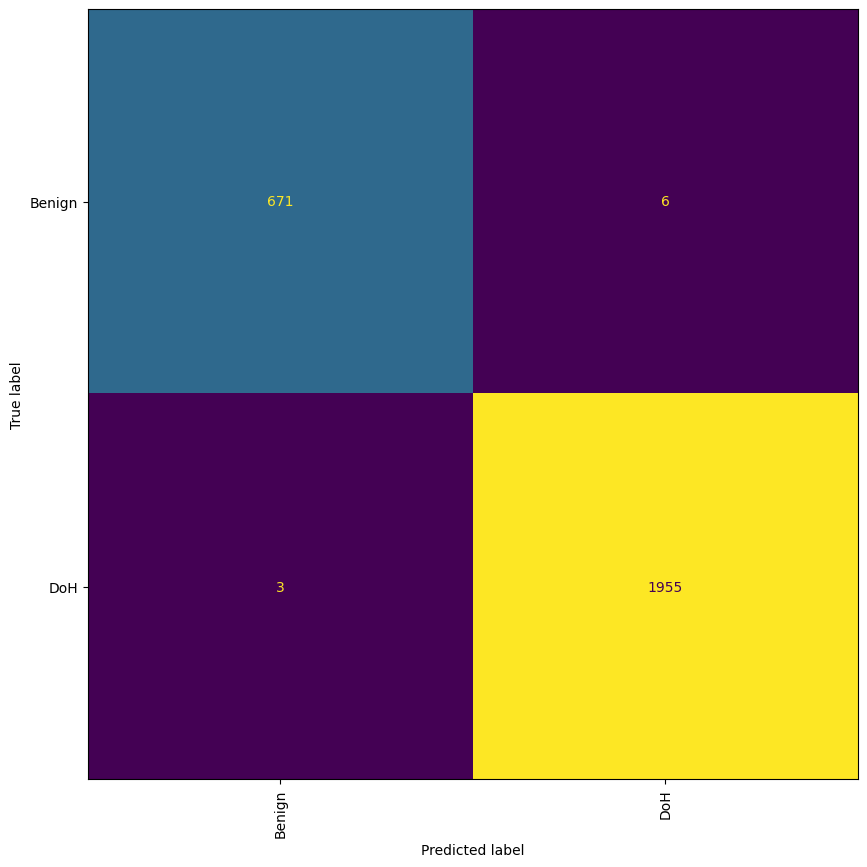

In [46]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(label_test, flow_pred, display_labels=Class_list, xticks_rotation='vertical',
                                        ax=ax, colorbar=False)
plt.savefig(output_dir / 'ConfusionMatrix.pdf', bbox_inches="tight")

In [47]:
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


def cm_analysis(y_true, y_pred, filename, labels, classes, ymap=None, figsize=(17, 17)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      classes:   aliases for the labels. String array to be shown in the cm plot.
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    sns.set(font_scale=1)

    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.2f%%\n%d/%d' % (p, c, s)
            #elif c == 0:
            #    annot[i, j] = ''
            else:
                annot[i, j] = '%.2f%%\n%d' % (p, c)
    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize='true')
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm = cm * 100
    cm.index.name = 'True Label'
    cm.columns.name = 'Predicted Label'
    fig, ax = plt.subplots(figsize=figsize)
    plt.yticks(va='center')

    sns.heatmap(cm, annot=annot, fmt='', ax=ax, xticklabels=classes, cbar=True, cbar_kws={'format': PercentFormatter()},
                yticklabels=classes, cmap="Blues")
    plt.savefig(filename, bbox_inches='tight')

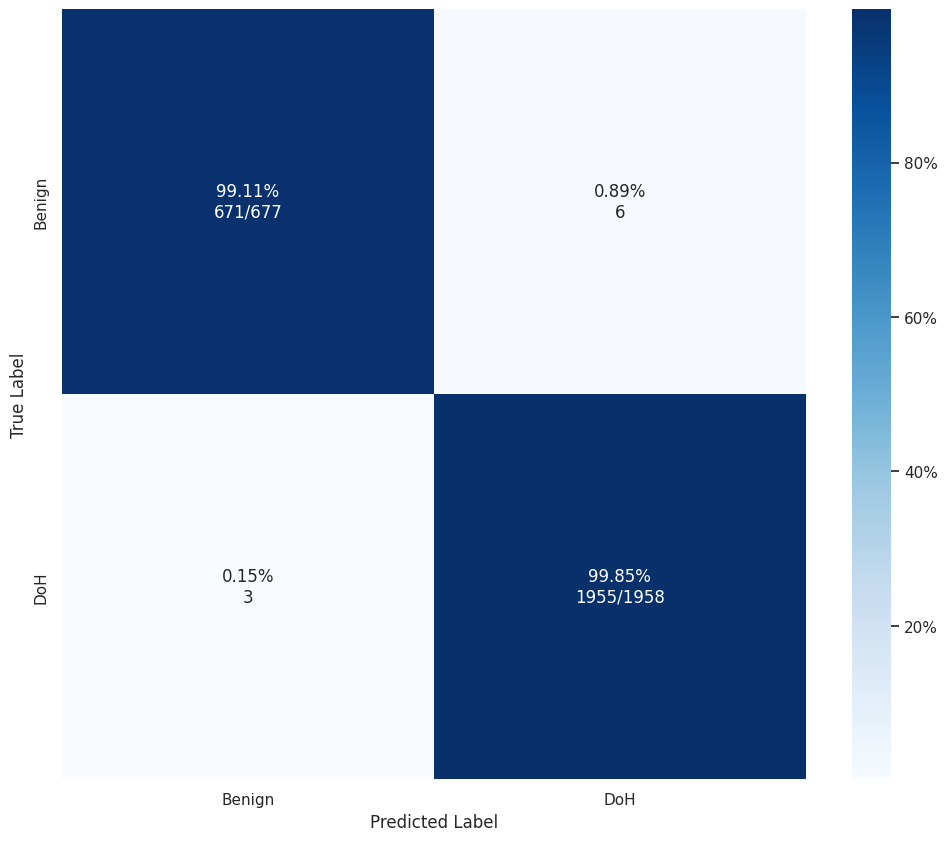

In [48]:
cm_analysis(y_true=label_test, y_pred=flow_pred, filename=output_dir / 'ConfusionMatrix_nom.pdf', labels=[0, 1],
            classes=Class_list, figsize=(12, 10))

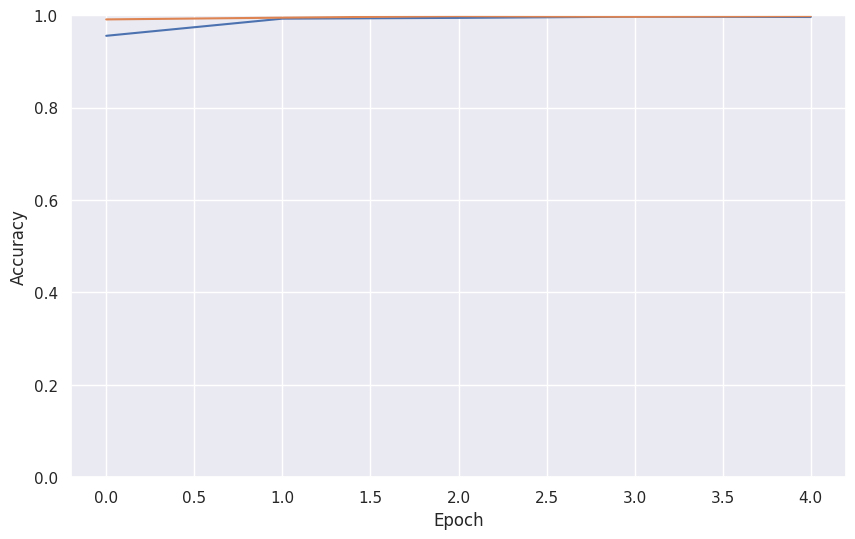

In [49]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['sparse_categorical_accuracy'], label='accuracy')
plt.plot(
    history.history['val_sparse_categorical_accuracy'], label='val_accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.savefig(output_dir / "normal_model_Accuracy.pdf")

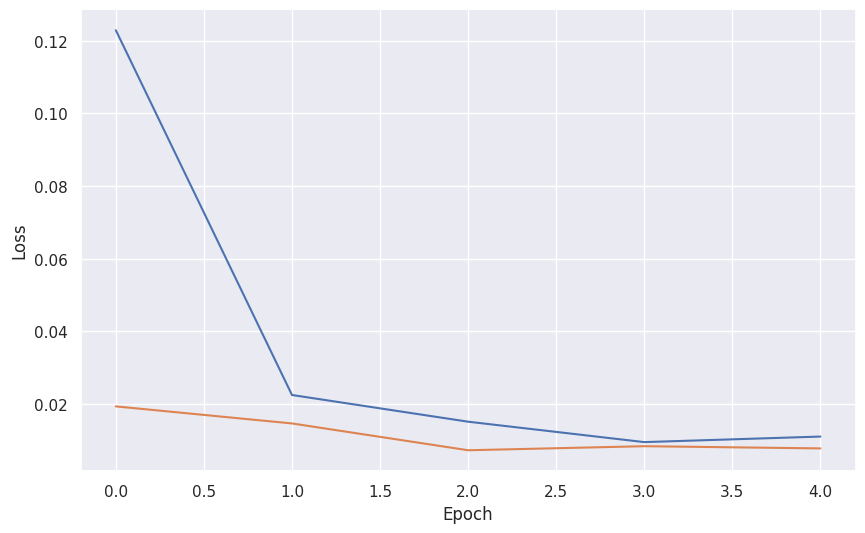

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig(output_dir / "normal_model_Loss.pdf")
